# 2018 NINTENDO SENTIMENT

## Import Relevant Libraries

In [1]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime
from datetime import timezone
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 
import pickle
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nintendo.functions import (
    create_text2_without_hash_ats_links,
    remove_punctuation,
    make_lower_case,
    lemmatize_text,
    remove_stop_words,
    remove_just_links,
    vader_sentiment,
    trend_line_by_time,
    automated_radar_plots,
    unique_seconds_list,
    second_groupings,
    trend_line_by_5_sec,
    trend_2018_5_secs,
    trend_2018_select_secs,
    radar_2018,
    )

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurashummonmaass/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Fully Automated Functions

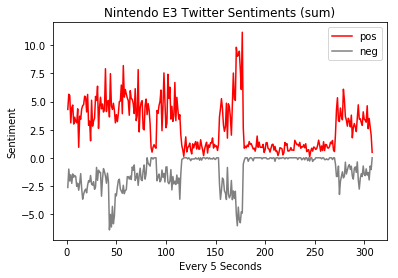

In [2]:
trend_2018_5_secs(sum_mean='sum')

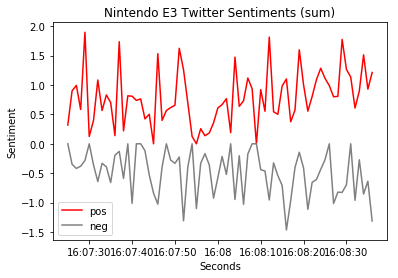

In [7]:
trend_2018_select_secs(start_time='16:07:24', 
                           end_time='16:08:36',
                           sum_mean='sum',
                           )

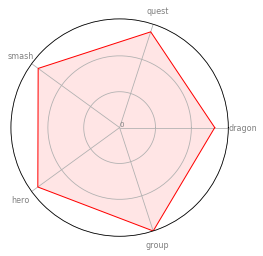

In [8]:
radar_2018(start_time='16:07:24', 
               end_time='16:08:36',
               which_five='top',
               )

## Load Tweets to DF

In [ ]:
tweets = []
for line in open('NintendoTweets.json', 'r'):
    if len(line)>1:
        tweets.append(json.loads(line))

Flatten json and turn into pandas df.

In [ ]:
df = json_normalize(tweets)

## DF Cleaning

In [ ]:
len(df)

Select relevant columns

In [ ]:
df = df[['user.id', 'text', 'lang', 'created_at', 'timestamp_ms']]

Filter for English only (also uses only relevant columns)  

In [ ]:
 df = df.loc[df['lang'] == 'en']

Add a .time. column showing H:M:S    

In [ ]:
#outputs str
df['.time.'] = df['created_at'].map(lambda x: x[11:19]) 

In [ ]:
#outputs datetime.time
df['datetime'] = df['.time.'].map(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
df['datetime'] = df['datetime'].map(lambda x: x.time())

Remove any duplicate rows.

In [ ]:
df = df.drop_duplicates(subset=None, keep='first')

## EDA

In [ ]:
len(df)

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
print(df['.time.'].min())
print(df['.time.'].max())

## Text Cleaning

Remove any words starting with: #, @, or http and put cleaned text into new 'text2' column.

In [ ]:
create_text2_without_hash_ats_links(df)

Remove punctuation

In [ ]:
remove_punctuation(df)

Make lower case

In [ ]:
make_lower_case(df)

Lemmatize

In [ ]:
lemmatize_text(df)

Remove stop words

In [ ]:
remove_stop_words(df)

Remove links again (some links left over if they began with punctuation)

In [ ]:
remove_just_links(df)

Reset Index

In [ ]:
df = df.reset_index()

## Vader Sentiments

In [ ]:
vader_output = vader_sentiment(df)

In [ ]:
matrix_df = json_normalize(vader_output)

In [ ]:
df = pd.concat([df, matrix_df], axis=1)

## PICKLE DF

In [ ]:
# with open ('./nintendo/pkl/2018_df.pkl', 'wb') as f:
#     pickle.dump(df, f)

In [ ]:
with open ('./nintendo/pkl/2019_df.pkl', 'rb') as f:
    df = pickle.load(f)

## Trend Lines - Grouped by 5 Seconds

In [ ]:
unique_seconds = unique_seconds_list(df)

In [ ]:
list_of_second_groups = second_groupings(5, unique_seconds)

In [ ]:
seconds_dict = dict(zip(unique_seconds, list_of_second_groups))

Use the dictionary above to assign each tweet to a 5 second group

In [ ]:
df['5_seconds'] = df['.time.'].map(seconds_dict)

Trend line

In [ ]:
trend_line_by_5_sec(df, sum_mean="sum")

## Trend Lines - With Time Selector

In [ ]:
trend_line_by_time(df, 
                   start_time_str="16:07:24", 
                   end_time_str="16:10:36", 
                   sum_mean="sum"
                  )

## Radar Plots - With Time Selector

In [ ]:
automated_radar_plots(df, 
                       start_time='16:07:24', 
                       end_time='16:08:36', 
                       which_five='top')